<font color='green' size=6 > Xarray (aplicación): clustering de datos grillados

Elaborado por **Kevin Campos Sánchez**

Ayudante de cátedra del curso **TÉCNICAS DE PROGRAMACIÓN II** durante el ciclo académico 2022-II.

Universidad Nacional Agraria La Molina, Lima-Perú

02/12/2022

* Shapefile de países: https://figshare.com/articles/dataset/ne_50m_admin_0_countries_zip/13692943

* Datos PISCO: https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/

In [ ]:
#@title Preparación de entorno

!pip install 'xarray==0.19.0' &> /dev/null
!pip install rioxarray &> /dev/null
!pip install deafrica_tools &> /dev/null
!pip install geopandas &> /dev/null
!pip install 'cartopy==0.18.0' &> /dev/null
!pip install shapely --no-binary shapely --force &> /dev/null

import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, missingno as msno, seaborn as sns, xarray as xr, geopandas as gpd, rioxarray as rioxr
from datetime import datetime, timedelta
from google.colab import drive        # Conectar Google drive

drive.mount('/content/drive/')

path = '/content/drive/MyDrive/Aiiuda_meteo/(c) TProg_II/S_Xarray/'    # Directorio de trabajo #--------
os.chdir(path)          # Seleccionar carpeta de trabajo

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.version

'3.8.15 (default, Oct 12 2022, 19:14:39) \n[GCC 7.5.0]'

Lectura de PISCO tx monthly

In [ ]:
date_range = pd.date_range(start = datetime(1981,1,1), end = datetime(2016,12,31), freq = 'm').values

PISCOtx = xr.open_dataset(path + 'PISCOtm_tx_1981-2016.nc', decode_times=False)
PISCOtx['T'] = date_range
PISCOtx

<xarray.Dataset>
Dimensions:  (X: 145, T: 432, Y: 202)
Coordinates:
  * X        (X) float32 -81.45 -81.35 -81.25 -81.15 ... -67.25 -67.15 -67.05
  * T        (T) datetime64[ns] 1981-01-31 1981-02-28 ... 2016-11-30 2016-12-31
  * Y        (Y) float32 1.35 1.25 1.15 1.05 ... -18.45 -18.55 -18.65 -18.75
Data variables:
    tmax     (T, Y, X) float32 ...

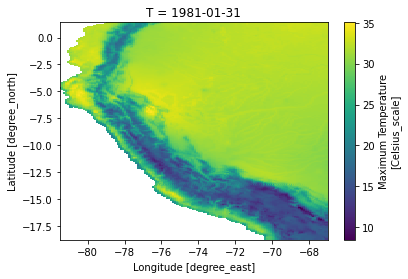

In [ ]:
PISCOtx.tmax.sel(T = '1981-01-31T00:00:00.000000000').plot()

Lectura del shapefile

In [ ]:
PERU = gpd.read_file(path + 'ne_50m_admin_0_countries.zip')
PERU = PERU.loc[PERU.SOVEREIGNT == 'Peru']  # Soberanía

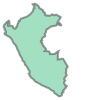

In [ ]:
PERU.geometry.values[0]

In [ ]:
PERU.crs    # EPSG:4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
PISCOtx = PISCOtx.rio.write_crs(PERU.crs)                 # Definir sistema de coordenadas de referencia
PISCOtx = PISCOtx.rio.clip(PERU.geometry, drop = True)    # Clip con shapefile

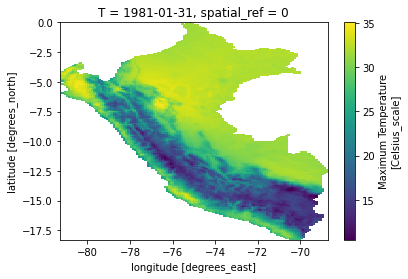

In [ ]:
PISCOtx.tmax.sel(T = '1981-01-31T00:00:00.000000000').plot()

In [ ]:
# Ver propiedades espaciales del DataArray
PISCOtx.rio.transform()
# PISCOtx.rio.crs()
# PISCOtx.spatial_ref

Affine(0.1, 0.0, -81.3,
       0.0, -0.10000000011871804, 2.1666042751555814e-08)

In [ ]:
PISCOtx     # Georeferenciación agrega spatial_ref

<xarray.Dataset>
Dimensions:      (Y: 183, X: 126, T: 432)
Coordinates:
  * Y            (Y) float64 -0.05 -0.15 -0.25 -0.35 ... -18.05 -18.15 -18.25
  * X            (X) float64 -81.25 -81.15 -81.05 ... -68.95 -68.85 -68.75
  * T            (T) datetime64[ns] 1981-01-31 1981-02-28 ... 2016-12-31
    spatial_ref  int64 0
Data variables:
    tmax         (T, Y, X) float32 nan nan nan nan nan ... nan nan nan nan nan

Cálculo de climatología

In [ ]:
PISCOtx_clim = PISCOtx.groupby('T.month').mean()
PISCOtx_clim

<xarray.Dataset>
Dimensions:      (Y: 183, X: 126, month: 12)
Coordinates:
  * Y            (Y) float64 -0.05 -0.15 -0.25 -0.35 ... -18.05 -18.15 -18.25
  * X            (X) float64 -81.25 -81.15 -81.05 ... -68.95 -68.85 -68.75
    spatial_ref  int64 0
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tmax         (month, Y, X) float32 nan nan nan nan nan ... nan nan nan nan

In [ ]:
PISCOtx_clim = PISCOtx_clim.rio.write_crs(PERU.crs)                 # Definir sistema de coordenadas de referencia
PISCOtx_clim = PISCOtx_clim.rio.clip(PERU.geometry, drop = True)    # Clip con shapefile

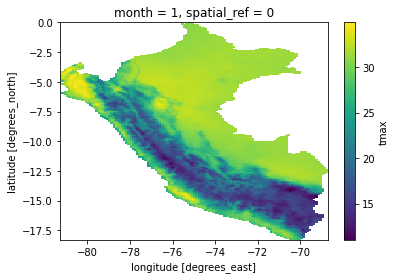

In [ ]:
PISCOtx_clim.tmax.sel(month = 1).plot()

Preprocesamiento: conversión a DataFrame

In [ ]:
DF = PISCOtx_clim.to_dataframe(dim_order = ['X', 'Y', 'month'])\
                 .drop('spatial_ref', axis = 1)
DF

tmax
X      Y      month      
-81.25 -0.05  1       NaN
              2       NaN
              3       NaN
              4       NaN
              5       NaN
...                   ...
-68.75 -18.25 8       NaN
              9       NaN
              10      NaN
              11      NaN
              12      NaN

[276696 rows x 1 columns]

In [ ]:
for x,y,m in DF.index[:5]:      # MultiIndex = Index de tuplas
    print( f'{x},{y}' , m )

-81.25,-0.04999997839331627 1
-81.25,-0.04999997839331627 2
-81.25,-0.04999997839331627 3
-81.25,-0.04999997839331627 4
-81.25,-0.04999997839331627 5


In [ ]:
DF.index = pd.MultiIndex.from_tuples([(f'{x},{y}', m) for x,y,m in DF.index])
DF.head(14)

tmax
-81.25,-0.04999997839331627 1    NaN
                            2    NaN
                            3    NaN
                            4    NaN
                            5    NaN
                            6    NaN
                            7    NaN
                            8    NaN
                            9    NaN
                            10   NaN
                            11   NaN
                            12   NaN
-81.25,-0.1499999761581421  1    NaN
                            2    NaN

In [ ]:
DF = DF.unstack()
DF

tmax                                            
                              1   2   3   4   5   6   7   8   9   10  11  12
-68.75,-0.04999997839331627  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-68.75,-0.1499999761581421   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-68.75,-0.2499999850988388   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-68.75,-0.34999996423721313  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-68.75,-0.44999998807907104  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
...                          ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
-81.25,-9.550000190734863    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-81.25,-9.649999618530273    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-81.25,-9.75                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-81.25,-9.850000381469727    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
-81.25,-9.949999809265137    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

[23058 rows x 12 columns]

In [ ]:
DF = DF.T.droplevel(level=0).T\
        .dropna()   # Eliminar valores nulos (Al ser PISCO, no contiene mas que en las grillas sin datos)
DF

,1,2,3,4,5,6,7,8,9,10,11,12
"-68.75,-12.449999809265137",31.345116,31.351341,31.627346,31.612143,30.547220,30.402283,31.242424,32.696335,33.451626,32.979950,32.097626,31.511427
"-68.75,-12.550000190734863",31.366568,31.354963,31.636549,31.612963,30.540236,30.381216,31.240501,32.697769,33.478592,33.007618,32.126278,31.530100
"-68.85000610351562,-12.25",31.168766,31.070503,31.484383,31.449537,30.456919,30.339596,31.195160,32.648514,33.407711,32.925182,32.062489,31.404087
"-68.85000610351562,-12.350000381469727",31.224318,31.189758,31.561411,31.493111,30.478872,30.322706,31.173658,32.614056,33.397743,32.923813,32.050186,31.410330
"-68.85000610351562,-12.449999809265137",31.363600,31.337721,31.648512,31.651184,30.550755,30.381405,31.226746,32.686188,33.460289,32.990662,32.109703,31.540171
...,...,...,...,...,...,...,...,...,...,...,...,...
"-81.25,-4.349999904632568",30.888763,31.756287,31.851336,31.267769,30.039371,28.215807,27.054619,26.289782,26.243670,26.507059,27.534218,29.528269
"-81.25,-4.449999809265137",31.755795,32.921364,32.826717,31.936287,30.249763,28.135777,26.998884,26.383127,26.685551,27.304945,28.255064,30.127768
"-81.25,-4.550000190734863",31.586348,32.916641,32.319614,31.507046,29.875454,27.701023,26.406303,25.705753,25.847195,26.629919,27.556438,29.769814
"-81.25,-4.650000095367432",31.924015,33.423912,32.659508,31.775160,29.852448,27.661551,26.420097,25.762053,26.177647,27.109591,28.104525,30.059166


Preprocesamiento: estandarización

In [ ]:
from sklearn.preprocessing import StandardScaler
Sc = StandardScaler()   # Nota: utiliza ddof=0, según las referencias no afecta mucho al resultado
DF = pd.DataFrame(Sc.fit_transform(DF), index = DF.index, columns = DF.columns)
DF

,1,2,3,4,5,6,7,8,9,10,11,12
"-68.75,-12.449999809265137",0.753722,0.777649,0.823809,0.862145,0.802083,0.863222,0.982158,1.037940,1.062936,0.972335,0.860259,0.792614
"-68.75,-12.550000190734863",0.757118,0.778221,0.825271,0.862281,0.800827,0.859446,0.981823,1.038179,1.067419,0.977029,0.865305,0.795751
"-68.85000610351562,-12.25",0.725805,0.733318,0.801094,0.835113,0.785835,0.851985,0.973925,1.029949,1.055635,0.963042,0.854072,0.774581
"-68.85000610351562,-12.350000381469727",0.734599,0.752143,0.813333,0.842357,0.789785,0.848957,0.970180,1.024191,1.053978,0.962810,0.851905,0.775629
"-68.85000610351562,-12.449999809265137",0.756648,0.775499,0.827172,0.868635,0.802719,0.859480,0.979427,1.036244,1.064376,0.974152,0.862386,0.797443
...,...,...,...,...,...,...,...,...,...,...,...,...
"-81.25,-4.349999904632568",0.681480,0.841570,0.859398,0.804895,0.710704,0.471256,0.252715,-0.032594,-0.135404,-0.125892,0.056678,0.459438
"-81.25,-4.449999809265137",0.818735,1.025479,1.014376,0.916032,0.748561,0.456909,0.243007,-0.016996,-0.061940,0.009482,0.183613,0.560155
"-81.25,-4.550000190734863",0.791911,1.024733,0.933803,0.844673,0.681210,0.378972,0.139790,-0.130185,-0.201319,-0.105047,0.060591,0.500018
"-81.25,-4.650000095367432",0.845365,1.104806,0.987808,0.889246,0.677070,0.371895,0.142193,-0.120777,-0.146381,-0.023663,0.157105,0.548630


K means

In [ ]:
# Primer clustering
X = DF.to_numpy() # index = samples o muestras, columns = features/variables

from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, tol=1e-04, n_init = 10, random_state = 0)
km.fit(X)

# ¿Cómo escogemos el número de clústers?

KMeans(n_clusters=3, random_state=0)

In [ ]:
km.labels_

array([2, 2, 2, ..., 2, 2, 0], dtype=int32)

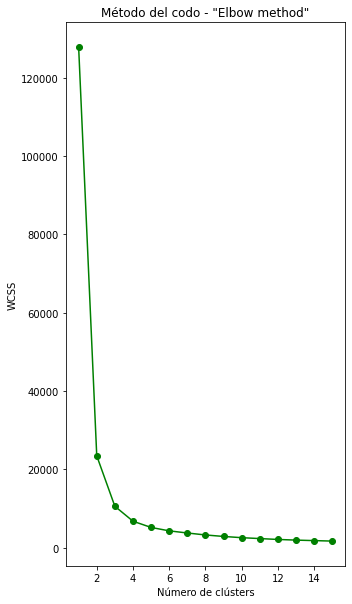

In [ ]:
X = DF.to_numpy() # index = samples o muestras, columns = features/variables
# Esta estación (muestra) con estas normales mensuales (características observadas por mes) siguen un patrón común a la clase K
########
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 15+1):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, tol=1e-04, n_init = 10, random_state = 0)
    km.fit(X)
    wcss.append(km.inertia_)

fig, ax = plt.subplots(1,1, figsize = (5,10))
ax.plot(range(1, 15+1), wcss, 'go-')
ax.set_title('Método del codo - "Elbow method"')
ax.set_xlabel('Número de clústers')
ax.set_ylabel('WCSS') #within cluster sum of squares
# WCSS (Within-Cluster Sum of Square) = sum( ( distancia clúster-observado ) ** 2 )
# Mayores valores de K podrían generar menores WCSS, pero requerirá de más tiempo de procesamiento
# Menores valores de K podrían generar mayores WCSS, por lo que los clústeres no representarán bien los agrupamientos
# K óptimo: valor donde se dé un punto de inflexión, es decir, donde el WCSS tome un valor "bajo", que para valores mayores a ese k cambie poco
plt.show()  # K aparenta ser igual a 3, pero no es claro

Para K = 2:  0.7211012
Para K = 3:  0.6719616
Para K = 4:  0.6315728
Para K = 5:  0.591233
Para K = 6:  0.54977214
Para K = 7:  0.5194483
Para K = 8:  0.48263535
Para K = 9:  0.53282315
Para K = 10:  0.44314572
Para K = 11:  0.44752786
Para K = 12:  0.42294863
Para K = 13:  0.39792082
Para K = 14:  0.3737205
Para K = 15:  0.37518963
Para K = 16:  0.36947772
Para K = 17:  0.36660063
Para K = 18:  0.36319697
Para K = 19:  0.3631578
Para K = 20:  0.35305524
Para K = 21:  0.3493417


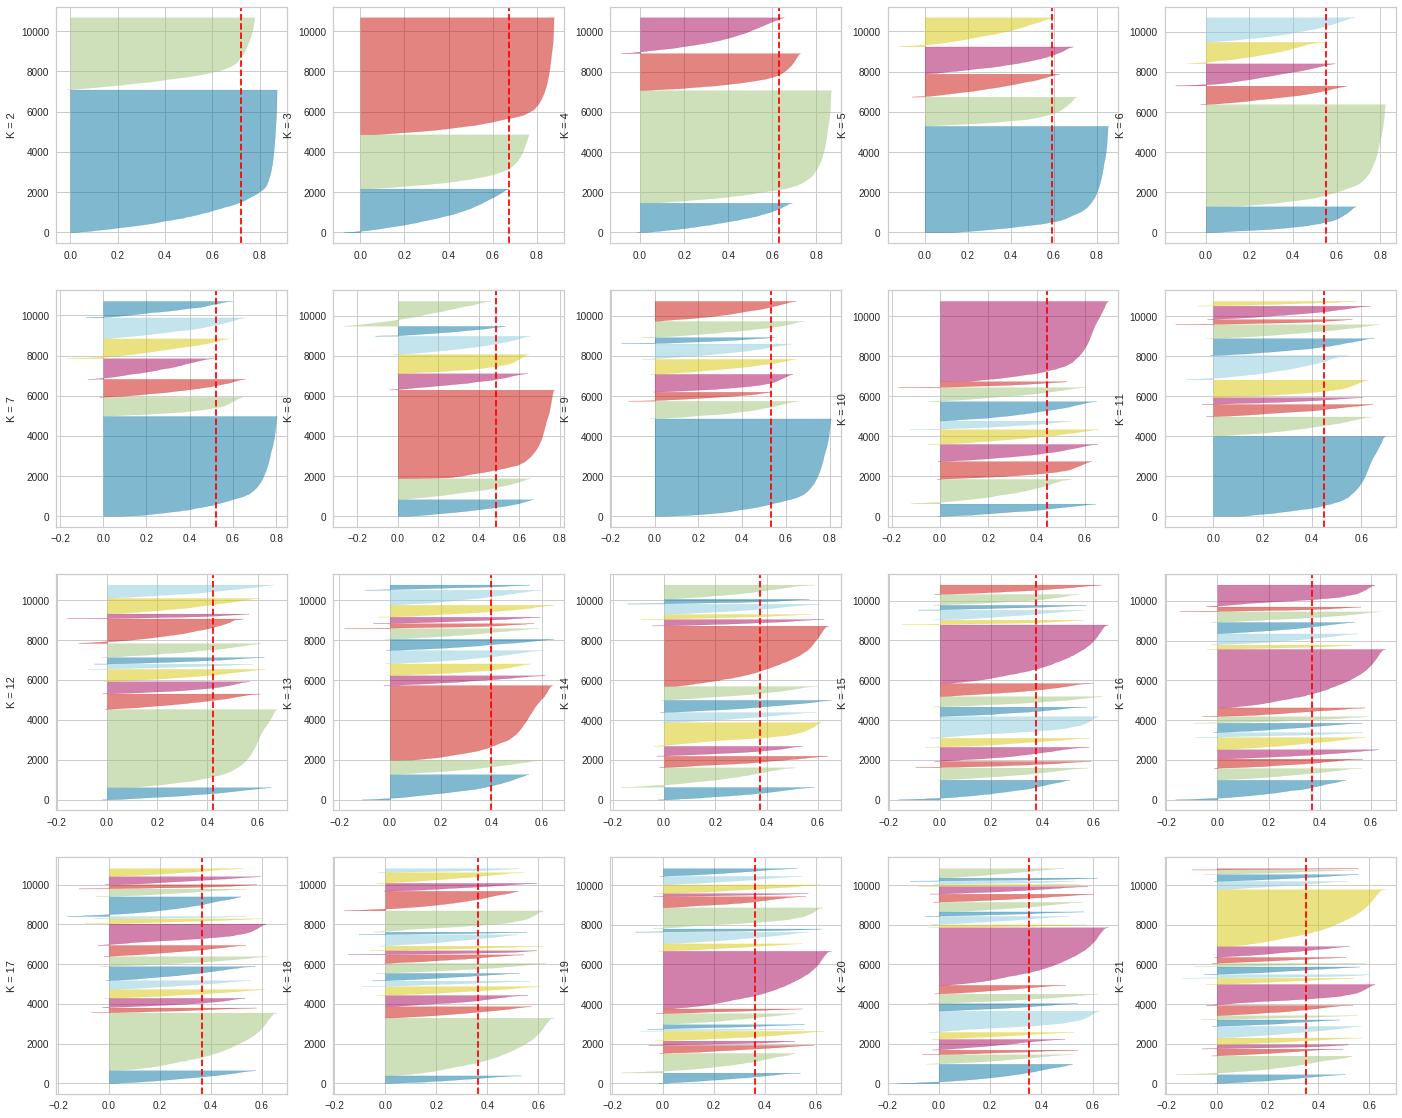

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer 

fig, Ax = plt. subplots(4,5, figsize=(24,20))
for i,ax in enumerate(Ax.flatten(), start = 2): # Si parte desde 1 o 0 salta error
    km = KMeans(n_clusters=i, init= 'k-means++', max_iter= 300, tol=1e-04, n_init= 10, random_state = 0)

    visualizador = SilhouetteVisualizer(km, colors= 'yellowbrick' , ax=ax) 
    visualizador.fit(X)
    ax.set_ylabel(f'K = {i}')
    print(f'Para K = {i}: ',visualizador.silhouette_score_)

In [ ]:
Clusters = pd.DataFrame(index = DF.index)
for i in [3,4,5,6,9,14,21]: # Si parte desde 1 o 0, salta error
    km = KMeans(n_clusters=i, init= 'k-means++', max_iter= 300, n_init= 10, tol=1e-04, random_state = 0)
    y_km = km.fit_predict(X)

    Clusters[f'K_{i}'] = y_km

# X: array de pares ordenados
# y_km: clúster

In [ ]:
Clusters

,K_3,K_4,K_5,K_6,K_9,K_14,K_21
"-68.75,-12.449999809265137",2,1,0,1,0,8,16
"-68.75,-12.550000190734863",2,1,0,1,0,8,16
"-68.85000610351562,-12.25",2,1,0,1,0,8,16
"-68.85000610351562,-12.350000381469727",2,1,0,1,0,8,16
"-68.85000610351562,-12.449999809265137",2,1,0,1,0,8,16
...,...,...,...,...,...,...,...
"-81.25,-4.349999904632568",2,3,4,3,6,9,13
"-81.25,-4.449999809265137",2,1,4,3,6,12,13
"-81.25,-4.550000190734863",2,3,4,3,6,9,13
"-81.25,-4.650000095367432",2,3,4,3,6,12,13


In [ ]:
Clusters.index.str.split(',')

Index([            ['-68.75', '-12.449999809265137'],
                   ['-68.75', '-12.550000190734863'],
                    ['-68.85000610351562', '-12.25'],
       ['-68.85000610351562', '-12.350000381469727'],
       ['-68.85000610351562', '-12.449999809265137'],
       ['-68.85000610351562', '-12.550000190734863'],
       ['-68.85000610351562', '-12.649999618530273'],
       ['-68.95000457763672', '-12.050000190734863'],
       ['-68.95000457763672', '-12.149999618530273'],
                    ['-68.95000457763672', '-12.25'],
       ...
                     ['-81.14999389648438', '-4.75'],
        ['-81.14999389648438', '-4.849999904632568'],
        ['-81.14999389648438', '-4.949999809265137'],
        ['-81.14999389648438', '-5.150000095367432'],
        ['-81.14999389648438', '-5.949999809265137'],
                    ['-81.25', '-4.349999904632568'],
                    ['-81.25', '-4.449999809265137'],
                    ['-81.25', '-4.550000190734863'],
                 

In [ ]:
Clusters.index = pd.MultiIndex.from_tuples([(float(xy[1]), float(xy[0])) for xy in Clusters.index.str.split(',')], names = ['Y','X'])

Clusters

,,K_3,K_4,K_5,K_6,K_9,K_14,K_21
Y,X,,,,,,,
-12.45,-68.750000,2,1,0,1,0,8,16
-12.55,-68.750000,2,1,0,1,0,8,16
-12.25,-68.850006,2,1,0,1,0,8,16
-12.35,-68.850006,2,1,0,1,0,8,16
-12.45,-68.850006,2,1,0,1,0,8,16
...,...,...,...,...,...,...,...,...
-4.35,-81.250000,2,3,4,3,6,9,13
-4.45,-81.250000,2,1,4,3,6,12,13
-4.55,-81.250000,2,3,4,3,6,9,13


In [ ]:
Cluster_xr = Clusters.to_xarray()
Cluster_xr

<xarray.Dataset>
Dimensions:  (Y: 183, X: 126)
Coordinates:
  * Y        (Y) float64 -18.25 -18.15 -18.05 -17.95 ... -0.35 -0.25 -0.15 -0.05
  * X        (X) float64 -81.25 -81.15 -81.05 -80.95 ... -68.95 -68.85 -68.75
Data variables:
    K_3      (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    K_4      (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    K_5      (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    K_6      (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    K_9      (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    K_14     (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    K_21     (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

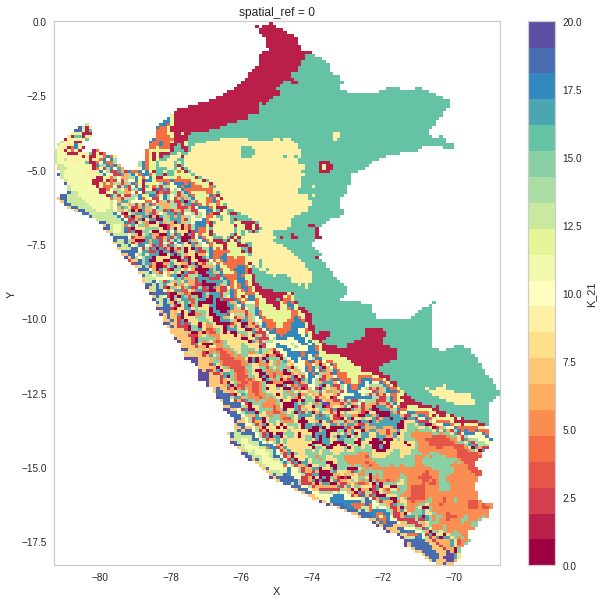

In [ ]:
k = 21   # K = [3,4,5,6,9,14,21] seleccionar plot de los k clústers

# cmap = plt.get_cmap('tab10', k)
# cmap = plt.get_cmap('viridis', k)
cmap = plt.get_cmap('Spectral', k)
cmap.set_bad(color = '#FFFFFF')   # color del nan

fig, ax = plt.subplots(figsize = (10,10))
Cluster_xr[f'K_{k}'].plot(cmap = cmap, ax = ax)

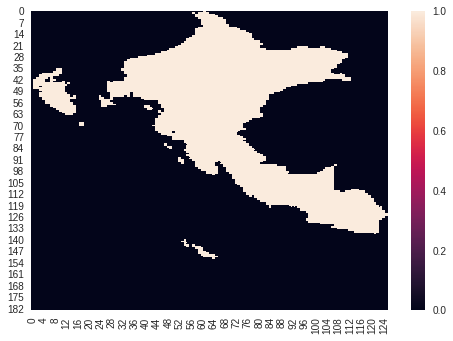

In [ ]:
sns.heatmap((Cluster_xr['K_5'] == 0).values[::-1])

In [ ]:
mask_k = (Cluster_xr['K_5'] == 0).values[::-1]
PISCOtx_K5_0 = PISCOtx.where(mask_k)
PISCOtx_K5_0

<xarray.Dataset>
Dimensions:      (T: 432, Y: 183, X: 126)
Coordinates:
  * Y            (Y) float64 -0.05 -0.15 -0.25 -0.35 ... -18.05 -18.15 -18.25
  * X            (X) float64 -81.25 -81.15 -81.05 ... -68.95 -68.85 -68.75
  * T            (T) datetime64[ns] 1981-01-31 1981-02-28 ... 2016-12-31
    spatial_ref  int64 0
Data variables:
    tmax         (T, Y, X) float32 nan nan nan nan nan ... nan nan nan nan nan

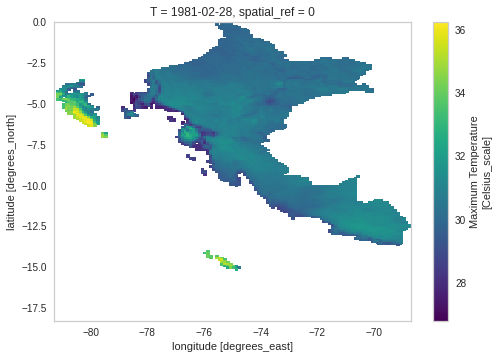

In [ ]:
PISCOtx_K5_0.isel(T = 1).tmax.plot()

Correlación con índices El Niño - IGP

In [ ]:
CIndices = pd.DataFrame()

url = 'http://met.igp.gob.pe/datos/icen.txt'    # ICEN - IGP
CI = pd.read_csv(url, sep = '\s+', skiprows = 17, header = None, names=['Year', 'Month', 'ICEN'],
                 dtype={'Year':int, 'Month':int, 'ICEN':float}, index_col = [0,1])
CIndices = pd.concat([CIndices, CI], axis = 1)

url = 'http://met.igp.gob.pe/datos/ecindex_ersstv5.txt' # E C index - IGP
CI = pd.read_csv(url, sep = '\s+', skiprows = 5, header = None, names=['Year', 'Month', 'E index', 'C index'], 
                 dtype={'Year':int, 'Month':int, 'E index':float, 'C index':float}, index_col = [0,1])
CIndices = pd.concat([CIndices, CI], axis = 1)

CIndices.index = pd.date_range('1880-01-01', periods = CIndices.shape[0], freq = 'M')
CIndices.index.set_names('T', inplace = True)

mask_CI = (datetime(1981,1,1) <= CIndices.index) & (CIndices.index <= datetime(2016,12,31))
CIndices = CIndices.loc[mask_CI]

In [ ]:
CIndices

,ICEN,E index,C index
T,,,
1981-01-31,-1.02,-1.24608,0.08076
1981-02-28,-1.02,-1.18468,-0.11271
1981-03-31,-0.74,-0.53377,-0.35491
1981-04-30,-0.58,-0.33401,-0.71335
1981-05-31,-0.60,-0.39276,-0.82221
...,...,...,...
2016-08-31,0.36,-0.34129,-0.10791
2016-09-30,0.37,0.15607,-0.47629
2016-10-31,0.32,-0.12942,-0.63096


In [ ]:
def Spearman_corr(x,y):
    from scipy.stats import spearmanr
    r,p = spearmanr(x,y)
    return r

PISCOtx_K5_0['Rho_K5'] = xr.apply_ufunc(Spearman_corr,
                                        PISCOtx.where(mask_k).tmax,
                                        CIndices['E index'].values,
                                        input_core_dims = [["T"],['T']],
                                        vectorize = True)

In [ ]:
PISCOtx_K5_0

<xarray.Dataset>
Dimensions:      (T: 432, Y: 183, X: 126)
Coordinates:
  * Y            (Y) float64 -0.05 -0.15 -0.25 -0.35 ... -18.05 -18.15 -18.25
  * X            (X) float64 -81.25 -81.15 -81.05 ... -68.95 -68.85 -68.75
  * T            (T) datetime64[ns] 1981-01-31 1981-02-28 ... 2016-12-31
    spatial_ref  int64 0
Data variables:
    tmax         (T, Y, X) float32 nan nan nan nan nan ... nan nan nan nan nan
    Rho_K5       (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan

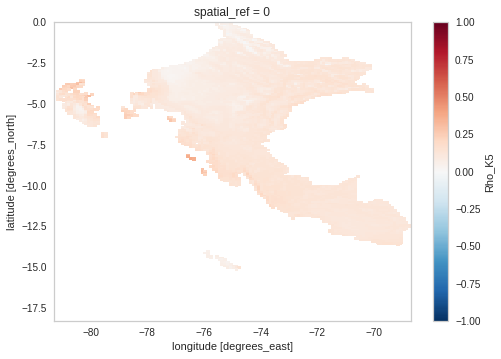

In [ ]:
PISCOtx_K5_0.Rho_K5.plot(cmap = 'RdBu_r', vmin = -1, vmax = 1)

In [ ]:
Cluster_xr = Cluster_xr.rio.write_crs(PERU.crs)  # Definir sistema de coordenadas de referencia

In [ ]:
Cluster_xr

<xarray.Dataset>
Dimensions:      (Y: 183, X: 126)
Coordinates:
  * Y            (Y) float64 -18.25 -18.15 -18.05 -17.95 ... -0.25 -0.15 -0.05
  * X            (X) float64 -81.25 -81.15 -81.05 ... -68.95 -68.85 -68.75
    spatial_ref  int64 0
Data variables:
    K_3          (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    K_4          (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    K_5          (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    K_6          (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    K_9          (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    K_14         (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    K_21         (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
Cluster_xr = Cluster_xr.rio.write_crs(PERU.crs)                 # Definir sistema de coordenadas de referencia

In [ ]:
from deafrica_tools.spatial import xr_vectorize
# https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Rasterise_vectorise.html
gdf = xr_vectorize(Cluster_xr['K_5'],
                   crs = Cluster_xr.rio.crs,
                   transform = Cluster_xr['K_5'].rio.transform(),
                   mask = mask_k)

gdf.head()

,attribute,geometry
0,NaN,"POLYGON ((57.00000 1.00000, 57.00000 2.00000, ..."
1,2.0,"POLYGON ((80.00000 19.00000, 80.00000 20.00000..."
2,2.0,"POLYGON ((77.00000 20.00000, 77.00000 21.00000..."
3,2.0,"POLYGON ((75.00000 21.00000, 75.00000 22.00000..."
4,2.0,"POLYGON ((73.00000 22.00000, 75.00000 22.00000..."
